In [20]:
# necessary imports 
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import random

In [21]:
# optimizations
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
 
config = dict(
    IMAGE_PATH="../../../dataset/NIH_WHOLE_DATASET/nih-2-class/",
    SAVED_PATH_MOB="../saved-models/mobilenet_v3v1.pth",
    SAVED_PATH_SHFL="../saved-models/shufflenetv1.pth",
    SAVED_PATH_BEST="../saved-models/mobilenet_v3v1_best.pth",
    lr = 0.001,
    EPOCHS = 30,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    pin_memory = True,
    num_workers = 4,
    channels_last = False,
    gpu_id = 6,
    USE_AMP=True,
    SEED = 42
    )

device = torch.device(f"cuda:{config['gpu_id']}" if torch.cuda.is_available() else 'cpu')
print(device)
random.seed(config['SEED'])
np.random.seed(config['SEED'])
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
    'general':transforms.Compose([
        torchvision.transforms.Resize((config['IMAGE_SIZE'])),
        torchvision.transforms.ToTensor()
    ]),
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

cuda:6


In [22]:
def plot_roc(fpr_tpr_auc): # name can be test train or validation
    plt.figure(figsize=(7,6))
    fpr,tpr,aucc = fpr_tpr_auc[0]
    plt.plot(fpr,tpr,label = 'auc:{:.2f}'.format(aucc))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()
    plt.title('ROC')
    plt.show()

def evaluate(model,loader,name='test'):
    model.eval()
    correct = 0;samples =0
    fpr_tpr_auc = {}
    pre_prob = []
    lab = []
    predicted_labels = []

    with torch.no_grad():
        for idx,(x,y) in enumerate(loader):
            x = transformations['test'](x)
            x = x.to(device)
            y = y.to(device)
            # model = model.to(device)

            scores = model(x)
            predict_prob = F.softmax(scores)
            _,predictions = predict_prob.max(1)

            predictions = predictions.to('cpu')
            y = y.to('cpu')
            predict_prob = predict_prob.to('cpu')

            predicted_labels.extend(list(predictions.numpy()))
            pre_prob.extend(list(predict_prob.numpy()))
            lab.extend(list(y.numpy()))

            correct += (predictions == y).sum()
            samples += predictions.size(0)

            print('batches done : ',idx,end='\r')

        print('correct are {:.2f}'.format(correct/samples))

    #     fpr_tpr_auc[f'fpr_{name}'], fpr_tpr_auc[f'tpr_{name}'], _ = roc_curve(lab,pre_prob[:,1])
    #     fpr_tpr_auc[f'auc_{name}'] = auc(fpr_tpr_auc[f'fpr_{name}'],fpr_tpr_auc[f'tpr_{name}'])
    
    # print(lab,pre_prob)
    pre_prob = np.array(pre_prob)
    fpr,tpr,_ = roc_curve(lab,pre_prob[:,1])
    aucc = auc(fpr,tpr)
    fpr_tpr_auc[0] = [fpr,tpr,aucc]
    model.train()
    return fpr_tpr_auc

In [23]:
images = torchvision.datasets.ImageFolder(root=config['IMAGE_PATH'],transform=transformations['general'])
print(len(images))
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[100000,10000,2120])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])

print(images.class_to_idx)



112120
{'abnormal': 0, 'normal': 1}


# shufflenet - 2class

In [24]:
shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
shufflenet.fc = nn.Linear(in_features=1024, out_features=2, bias=True)
torchmodel = shufflenet
torchmodel = torchmodel.to(device)
saved_model = torch.load(config['SAVED_PATH_SHFL'])
print(torchmodel.load_state_dict(saved_model))
torchmodel.eval()

<All keys matched successfully>


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

/DATA/sharma59/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


correct are 0.6566


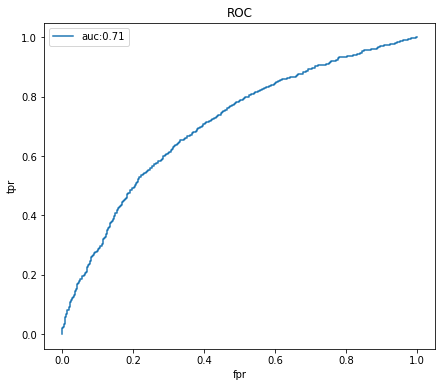

In [25]:
fta_test_shfl = evaluate(torchmodel,test_loader,name='test')
plot_roc(fta_test_shfl)